In [54]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                   LabelEncoder,
                                   PowerTransformer
                                  )



In [55]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')



## **Data Dictionary**
|Name|Description|Units|Type|
|----|-----------|-----|----|
|airline|The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.|none|category|
|flight|Flight stores information regarding the plane's flight code. It is a categorical feature.|none|category|
|Source City|City from which the flight takes off. It is a categorical feature having 6 unique cities.|none|category|
|Departure Time|This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.|none|category|
|Stops| A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.|none|category|
|Arrival Time| This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.|none|category|
|Destination City| City where the flight will land. It is a categorical feature having 6 unique cities.|none|category|
|Class| A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.|none|category|
|Duration| A continuous feature that displays the overall amount of time it takes to travel between cities in hours.|none|float|
|Price| Target variable stores information of the ticket price.|none|int|

In [56]:
# 1.1 Read from source and get basic info
df_raw.info(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [57]:
# 1.2 Get a sample
df_raw.sample(5)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
216392,216392,Air_India,AI-485,Delhi,Early_Morning,one,Morning,Kolkata,Business,29.17,10,48882
237417,237417,Vistara,UK-988,Mumbai,Night,one,Evening,Kolkata,Business,21.17,42,62045
207492,207492,Vistara,UK-819,Delhi,Afternoon,one,Night,Mumbai,Business,6.00,9,53164
212667,212667,Air_India,AI-803,Delhi,Early_Morning,zero,Morning,Bangalore,Business,2.75,11,32859
261539,261539,Vistara,UK-772,Kolkata,Morning,one,Evening,Delhi,Business,7.67,6,66063


In [58]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    #.astype({'target': np.float16})
    .iloc[:,1:]
    .drop("flight", axis = 1)
    .astype({"airline": "category", "source_city": "category", "departure_time": "category", "stops": "category", "arrival_time": "category", "destination_city": "category", "class": "category"})
   .assign(target_log=lambda df: df["target"].apply(
        lambda x: np.log(x + 1) if x == 0 else np.log(x)
    ))
    .assign(duration_log=lambda df: df["duration"].apply(
        lambda x: np.log(x + 1) if x == 0 else np.log(x)
    )
    
    )
        
) 
df_interim.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   duration          300153 non-null  float64 
 8   days_left         300153 non-null  int64   
 9   target            300153 non-null  int64   
 10  target_log        300153 non-null  float64 
 11  duration_log      300153 non-null  float64 
dtypes: category(7), float64(3), int64(2)
memory usage: 13.5 MB


In [59]:
df_interim["departure_time"].value_counts()

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [60]:
df_interim_transformed = df_interim.copy()
df_interim_transformed= df_interim_transformed.drop(["target", "duration"], axis=1)
df_interim_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300153 non-null  category
 1   source_city       300153 non-null  category
 2   departure_time    300153 non-null  category
 3   stops             300153 non-null  category
 4   arrival_time      300153 non-null  category
 5   destination_city  300153 non-null  category
 6   class             300153 non-null  category
 7   days_left         300153 non-null  int64   
 8   target_log        300153 non-null  float64 
 9   duration_log      300153 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [61]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim_transformed
    .copy()
    .reindex(
        columns=(
            ['target_log'] + 
            [c for c in df_interim_transformed.columns.to_list() if c not in ['target_log']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target_log        300153 non-null  float64 
 1   airline           300153 non-null  category
 2   source_city       300153 non-null  category
 3   departure_time    300153 non-null  category
 4   stops             300153 non-null  category
 5   arrival_time      300153 non-null  category
 6   destination_city  300153 non-null  category
 7   class             300153 non-null  category
 8   days_left         300153 non-null  int64   
 9   duration_log      300153 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [62]:
df.sample(10)

,target_log,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,duration_log
263280,10.891969,Vistara,Kolkata,Morning,one,Late_Night,Delhi,Business,37,2.674149
20280,9.315871,Air_India,Delhi,Evening,one,Night,Kolkata,Economy,2,3.317091
159088,9.366660,Air_India,Hyderabad,Evening,two_or_more,Afternoon,Mumbai,Economy,6,2.948641
125185,8.293800,GO_FIRST,Kolkata,Afternoon,zero,Evening,Delhi,Economy,36,0.947789
108833,8.129470,Indigo,Bangalore,Afternoon,one,Night,Kolkata,Economy,44,2.079442
67676,8.716863,Air_India,Mumbai,Early_Morning,one,Morning,Kolkata,Economy,35,3.222071
110293,9.686450,Vistara,Bangalore,Early_Morning,one,Evening,Hyderabad,Economy,7,3.511545
203749,8.837100,Indigo,Chennai,Evening,one,Night,Hyderabad,Economy,15,1.486140
121780,8.773539,Vistara,Kolkata,Night,one,Morning,Delhi,Economy,16,2.484907
192761,7.934513,Indigo,Chennai,Morning,one,Evening,Mumbai,Economy,41,2.259678


In [63]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target_log')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 193521 to 143788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target_log        240122 non-null  float64 
 1   airline           240122 non-null  category
 2   source_city       240122 non-null  category
 3   departure_time    240122 non-null  category
 4   stops             240122 non-null  category
 5   arrival_time      240122 non-null  category
 6   destination_city  240122 non-null  category
 7   class             240122 non-null  category
 8   days_left         240122 non-null  int64   
 9   duration_log      240122 non-null  float64 
dtypes: category(7), float64(2), int64(1)
memory usage: 8.9 MB


In [64]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


,count,mean,std,min,25%,50%,75%,max
target_log,240122.0,9.330416,1.112603,7.007601,8.472823,8.912608,10.657753,11.720517
days_left,240122.0,26.001533,13.558442,1.000000,15.000000,26.000000,38.000000,49.000000
duration_log,240122.0,2.283560,0.735436,-0.186330,1.921325,2.420368,2.783158,3.908617


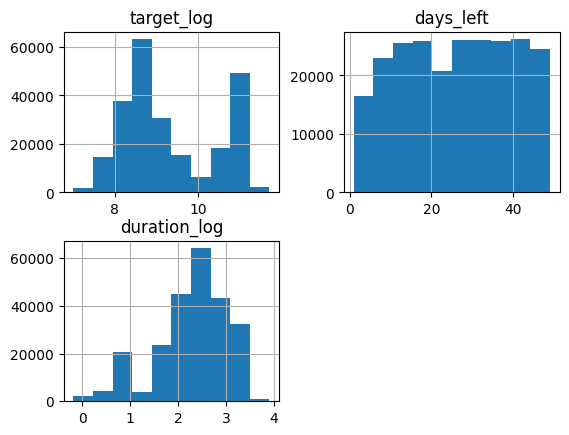

In [65]:
# Análisis univariado variables numéricas
df_train.hist()
plt.show()

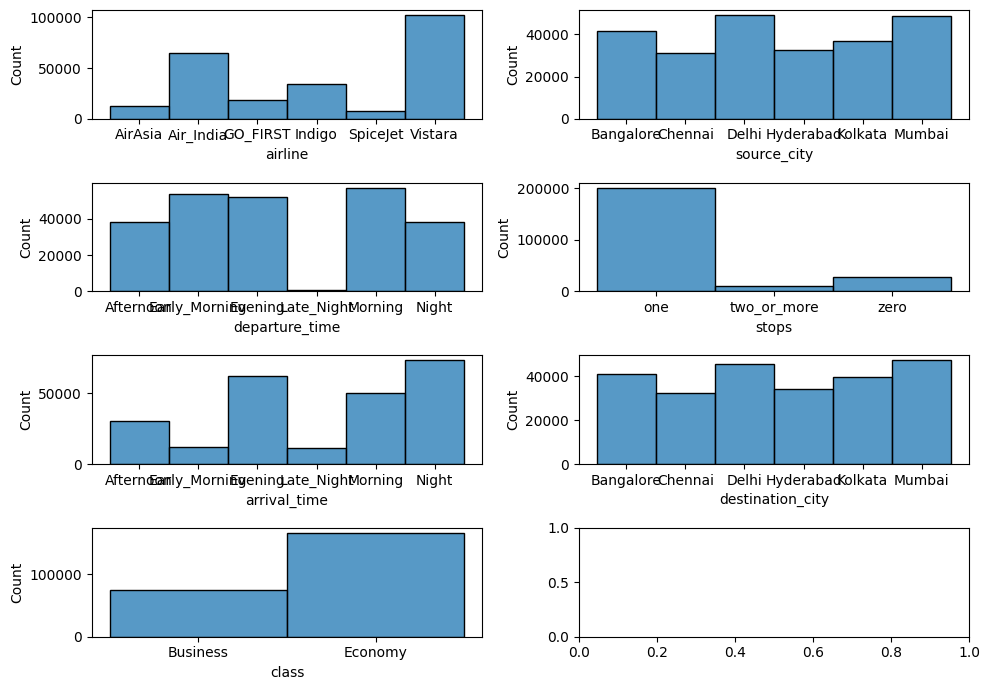

In [66]:
# Análisis univariado variables categóricas
fig, axis = plt.subplots(4, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x = "airline")
sns.histplot(ax = axis[0, 1], data = df_train, x = "source_city")
sns.histplot(ax = axis[1, 0], data = df_train, x = "departure_time")
sns.histplot(ax = axis[1, 1], data = df_train, x = "stops")
sns.histplot(ax = axis[2, 0], data = df_train, x = "arrival_time")
sns.histplot(ax = axis[2, 1], data = df_train, x = "destination_city")
sns.histplot(ax = axis[3, 0], data = df_train, x = "class")
plt.tight_layout()
plt.show()

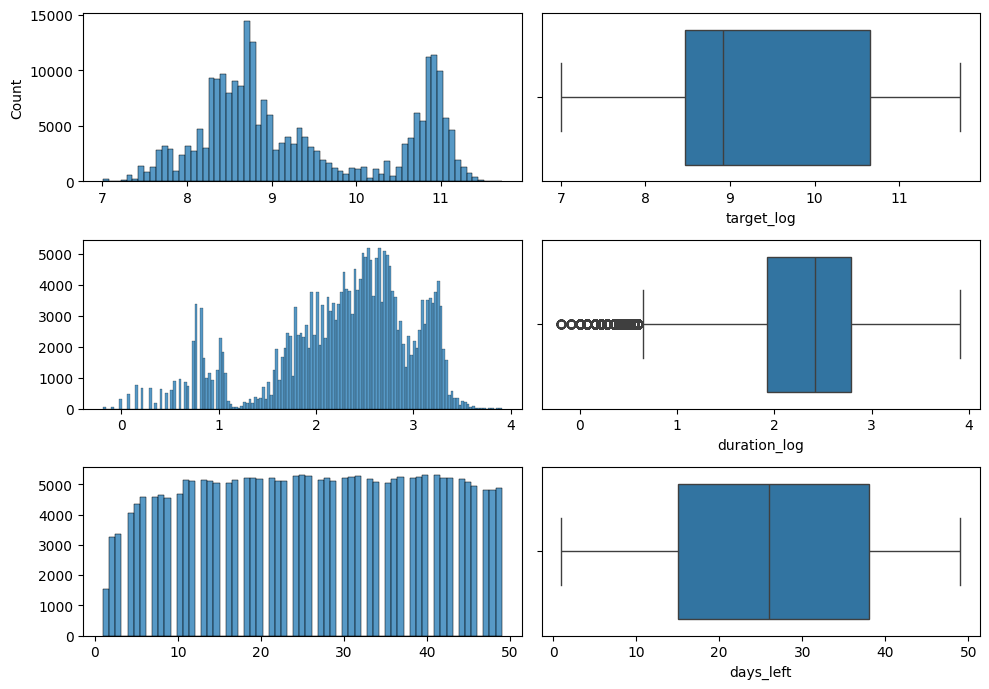

In [67]:
# Análisis variado variables numericas
fig, axis = plt.subplots(3, 2, figsize = (10, 7))
sns.histplot(ax = axis[0, 0], data = df_train, x= "target_log").set(xlabel = None)
sns.boxplot(ax = axis[0, 1], data = df_train, x = "target_log")
sns.histplot(ax = axis[1, 0], data = df_train, x = "duration_log").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_train, x = "duration_log")
sns.histplot(ax = axis[2, 0], data = df_train, x = "days_left").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[2, 1], data = df_train, x = "days_left")
# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

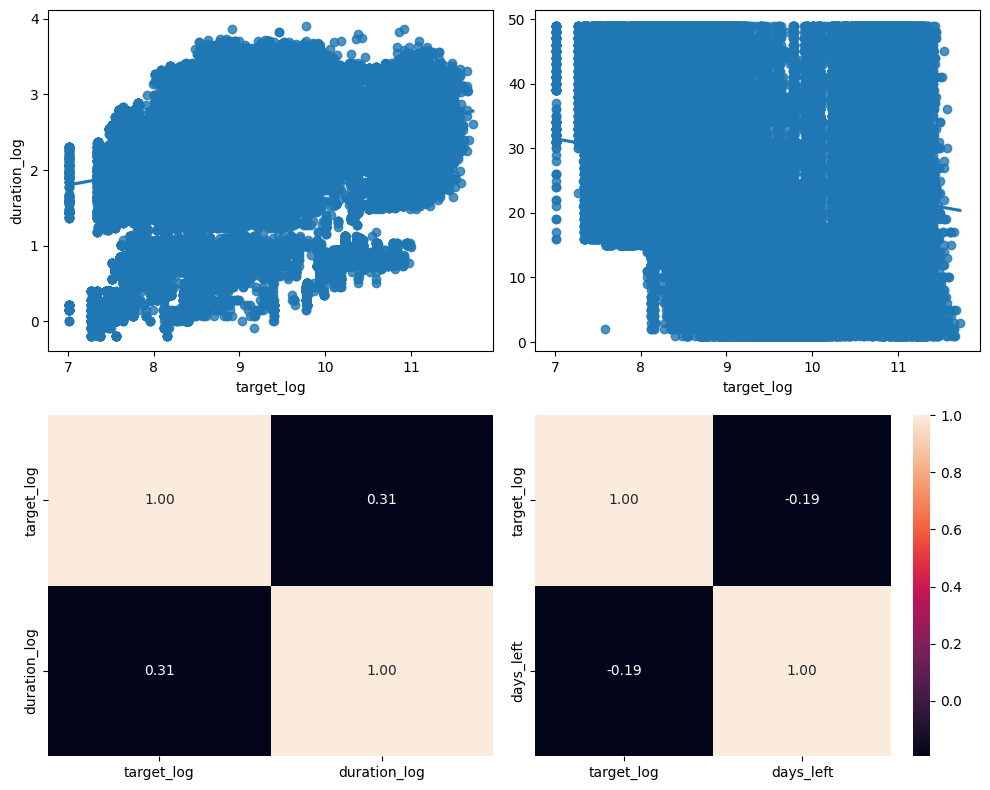

In [68]:
# Análisis bivariado variables categóricas
# Create a multiple scatter diagram
fig, axis = plt.subplots(2, 2, figsize=(10, 8))

# Gráficos de regresión y heatmaps
sns.regplot(ax=axis[0, 0], data=df_train, x="target_log", y="duration_log")
sns.heatmap(df_train[["target_log", "duration_log"]].corr(), annot=True, fmt=".2f", ax=axis[1, 0], cbar=False)
sns.regplot(ax=axis[0, 1], data=df_train, x="target_log", y="days_left").set(ylabel=None)
sns.heatmap(df_train[["target_log", "days_left"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

# Ajustar diseño
plt.tight_layout()
plt.show()

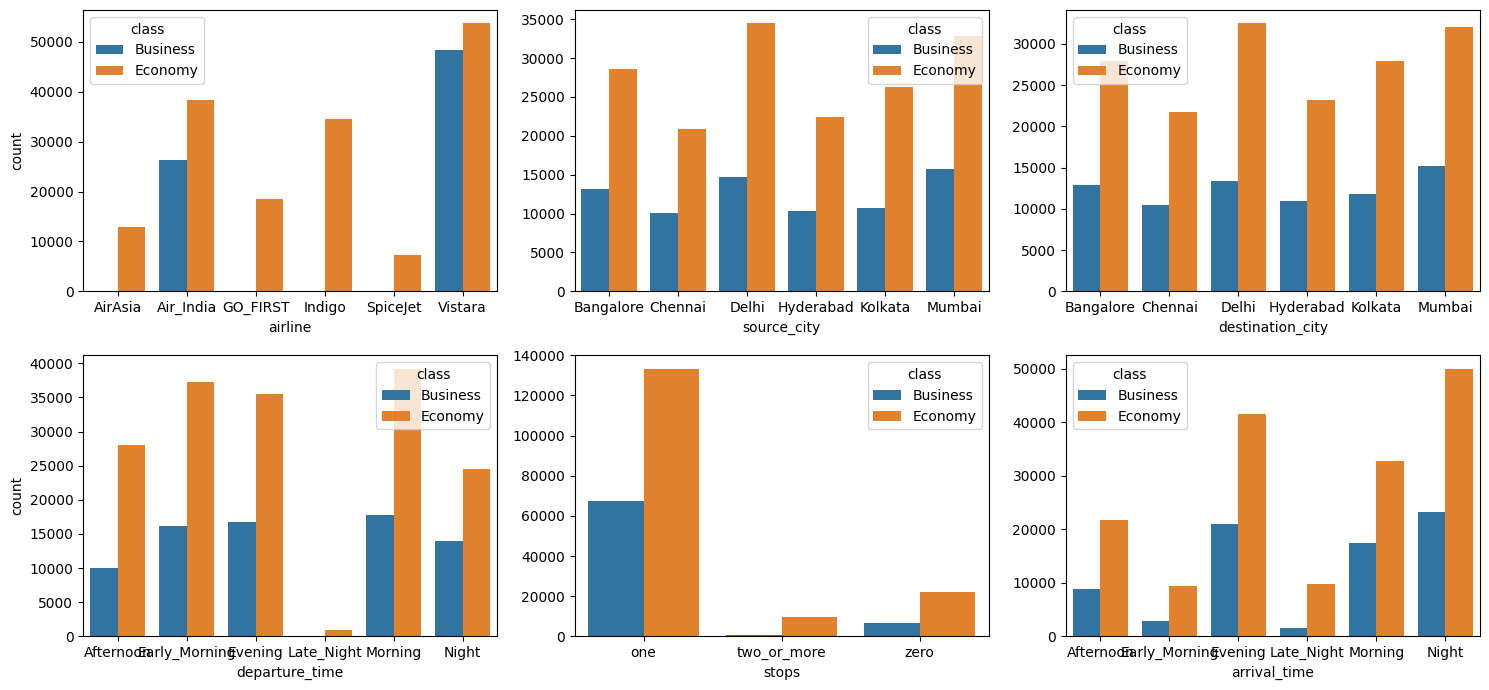

In [ ]:
#Análisis bivariado variables categóricas

fig, axis = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(ax = axis[0, 0], data = df_train, x = "airline", hue = "class")
sns.countplot(ax = axis[0, 1], data = df_train, x = "source_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[0, 2], data = df_train, x = "destination_city", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 0], data = df_train, x = "departure_time", hue = "class")
sns.countplot(ax = axis[1, 1], data = df_train, x = "stops", hue = "class").set(ylabel = None)
sns.countplot(ax = axis[1, 2], data = df_train, x = "arrival_time", hue = "class").set(ylabel = None)

plt.tight_layout()
#fig.delaxes(axis[1, 2])

plt.show()

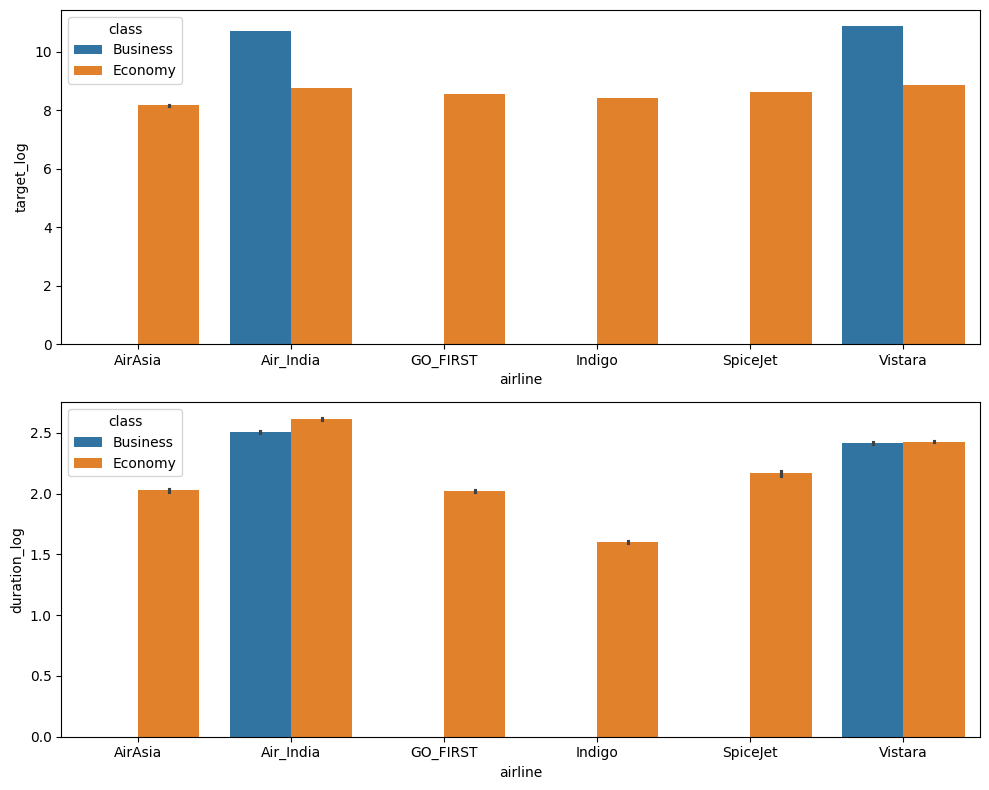

In [76]:
# Crear subgráficos
fig, axis = plt.subplots(2, 1, figsize=(10, 8))

# Primer gráfico
sns.barplot(ax=axis[0], data=df_train, x="airline", y="target_log", hue="class")

# Segundo gráfico
sns.barplot(ax=axis[1], data=df_train, x="airline", y="duration_log", hue="class")

# Ajustar diseño
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'Indigo'

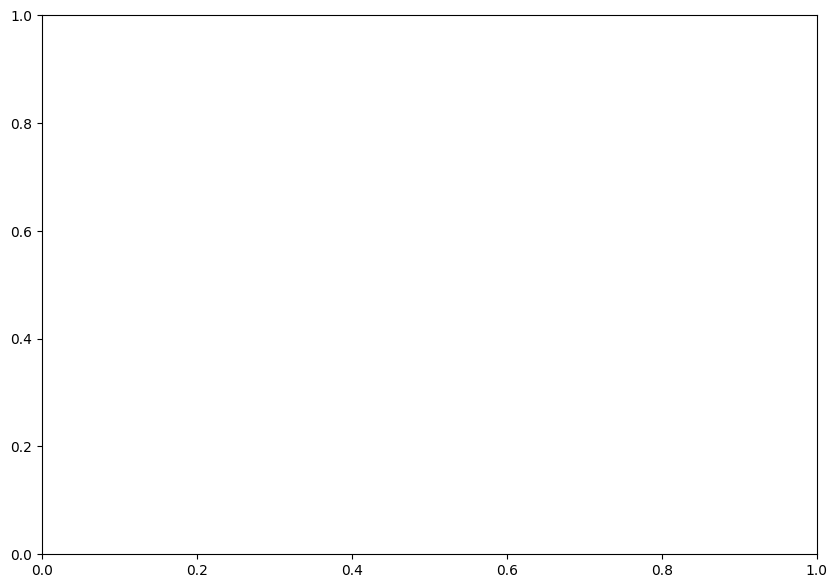

In [77]:
fig, axis = plt.subplots(figsize = (10, 7))

sns.heatmap(df_train[["target_log", "duration_log", "days_left", "airline", "source_city", "destination_city", "departure_time", "stops","arrival_time","class"]].corr(), annot = True, fmt = ".2f")
plt.tight_layout()
plt.show()

In [ ]:
label_encoder = LabelEncoder()
for col in df:
    df[col] = label_encoder.fit_transform(df[col])

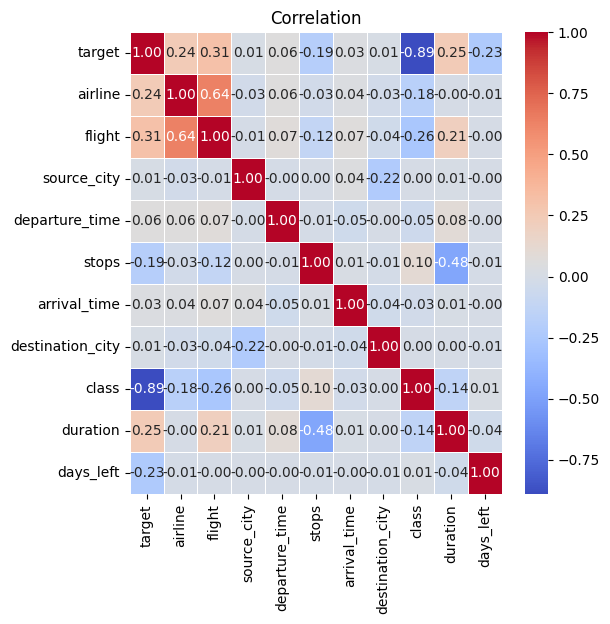

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 6))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation')
plt.show()

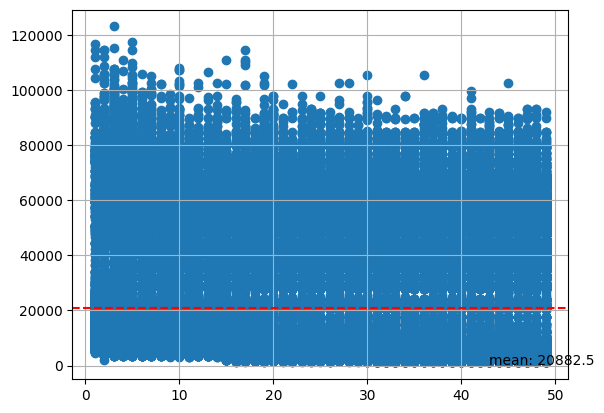

In [ ]:
# 3.5 Perform bivariate analysis as a trend
plt.scatter(df_train['days_left'],df_train['target'])
plt.axhline(df_train['target'].mean(),linestyle='--', c='r')
plt.annotate(text=f'mean: {df_train['target'].mean():.1f}', xy=(43,160))
plt.grid(True)
plt.show()

In [ ]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [ ]:
# 4.2 Modelo simple 
y_mean = np.repeat(df_train["target"].mean(),len(y_test))
print(f'MSE: {mean_squared_error(y_test,y_mean)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_mean))}')

print(f'MAE: {mean_absolute_error(y_test,y_mean)}')
print(f'R2: {r2_score(y_test,y_mean)}')

MSE: 516647660.3662721
RMSE: 22729.884741596736
MAE: 19780.48752245824
R2: -2.452362734439717e-06


In [ ]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

In [ ]:
# Pipelines because we have numeric and non numeric values
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # ignore unknow
])
num_proc = Pipeline([
    ('nimputer', SimpleImputer(strategy= 'mean')),
    ('scaler', MinMaxScaler())
])
processor = ColumnTransformer([
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [ ]:
reg_lin = Pipeline([
    ('proc', processor),
    ('lin', LinearRegression())
])

In [ ]:
# Modelo de regresión lineal 
reg_lin.fit(X_train,y_train)
y_pred = reg_lin.predict(X_test)
y_pred

/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([14172.13868971,  2344.10815769,  7749.99759112, ...,
       -3861.87464841,   793.42252992, 11438.65164134])

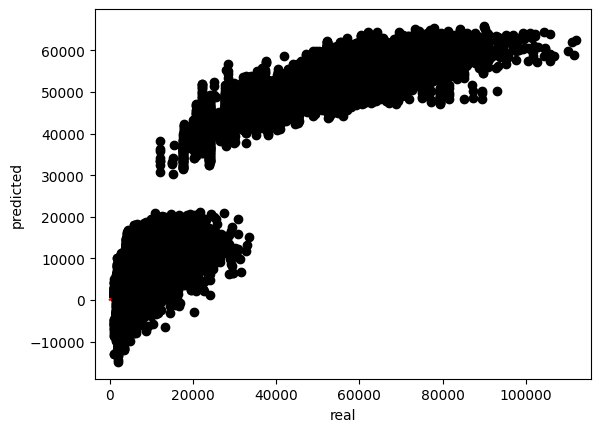

In [ ]:
plt.scatter(x= y_test, y= y_pred, c= 'k')
plt.plot([70,230], [70,230], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [ ]:
print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred))}')

print(f'MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')

MSE: 38521357.170365594
RMSE: 6206.557594219649
MAE: 4285.427368394316
R2: 0.9254396088595523
